# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

### (1) 라이브러리 불러오기

* **세부 요구사항**
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

### (2) 데이터 로딩
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 3) 데이터 읽어오기

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/16 Mini Project06/3-4일차. 장애인 이동권 개선을 위한 장애인 콜택시 대기시간 예측/open_data.csv')
data_w = pd.read_csv('/content/drive/MyDrive/16 Mini Project06/3-4일차. 장애인 이동권 개선을 위한 장애인 콜택시 대기시간 예측/weather.csv')

In [ ]:
data.head()

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


In [ ]:
data_w.head()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-03,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-04,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-05,-1.4,-9.6,0.0,71.0,28.0,9.14


#### 4) 기본정보 확인하기
* .info() 등을 이용하여 기본 정보를 확인합니다.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [ ]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


#### 5) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.


In [ ]:
data.rename(columns={'기준일':'Date', '차량운행':'operation', '접수건':'receive', '탑승건':'board', '평균대기시간':'mean_waiting_time', '평균요금':'mean_fare', '평균승차거리':'mean_distance'}, inplace=True)
data.head()

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [ ]:
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  # 날짜 타입으로 변환

In [ ]:
df['day'] = df['Date'].dt.day  # 일
df['day_of_week'] = df['Date'].dt.weekday  # 요일(0:월, 1:화, ...)
df['month'] = df['Date'].dt.month  # 월
df['year'] = df['Date'].dt.year  # 년
df.head()

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance,day,day_of_week,month,year
0,2015-01-01,213,1023,924,23.2,2427,10764,1,3,1,2015
1,2015-01-02,420,3158,2839,17.2,2216,8611,2,4,1,2015
2,2015-01-03,209,1648,1514,26.2,2377,10198,3,5,1,2015
3,2015-01-04,196,1646,1526,24.5,2431,10955,4,6,1,2015
4,2015-01-05,421,4250,3730,26.2,2214,8663,5,0,1,2015


### (2) 일별

#### 차량 운행수

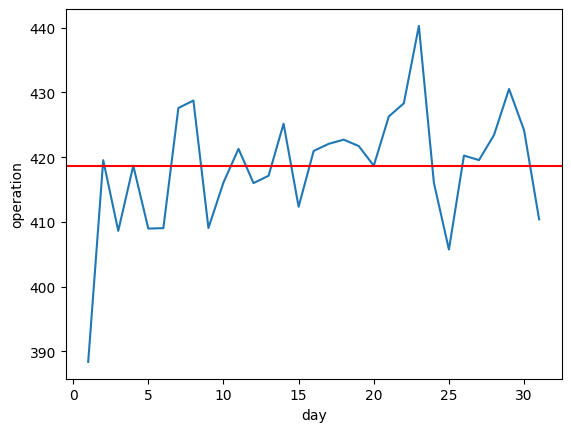

In [ ]:
df.groupby('day', as_index=True)['operation'].mean().plot()
plt.axhline(df['operation'].mean(), color='r')
plt.ylabel('operation')
plt.show()

#### 접수건, 탑승건

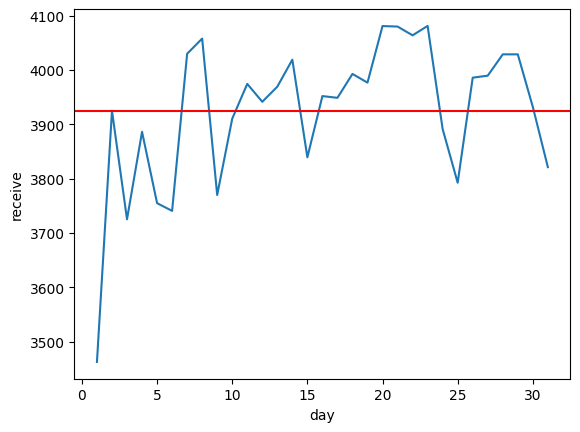

In [ ]:
# 접수건
df.groupby('day', as_index=True)['receive'].mean().plot()
plt.axhline(df['receive'].mean(), color='r')
plt.ylabel('receive')
plt.show()

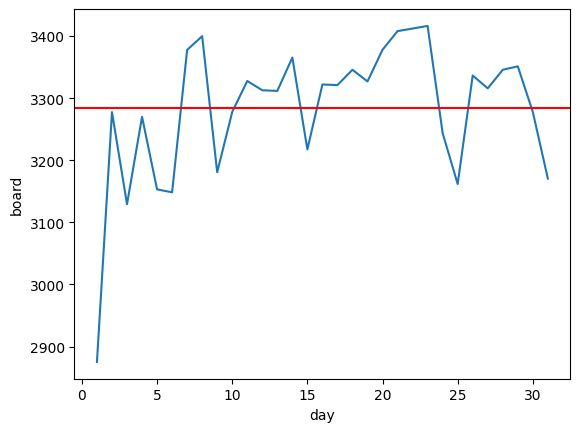

In [ ]:
# 탑승건
df.groupby('day', as_index=True)['board'].mean().plot()
plt.axhline(df['board'].mean(), color='r')
plt.ylabel('board')
plt.show()

#### 대기시간

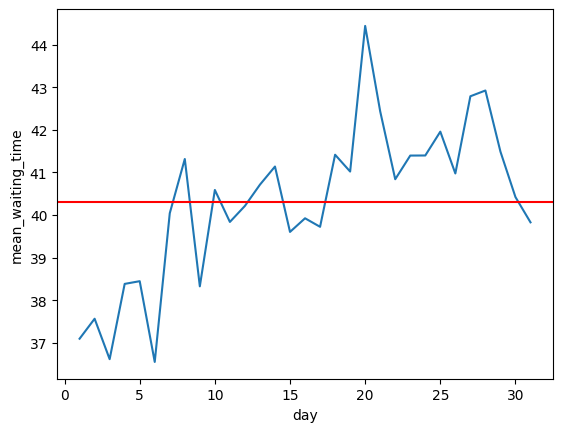

In [ ]:
df.groupby('day', as_index=True)['mean_waiting_time'].mean().plot()
plt.axhline(df['mean_waiting_time'].mean(), color='r')
plt.ylabel('mean_waiting_time')
plt.show()

#### 운임

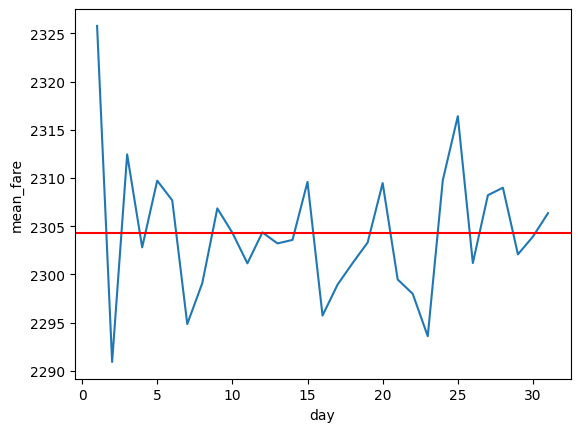

In [ ]:
df.groupby('day', as_index=True)['mean_fare'].mean().plot()
plt.axhline(df['mean_fare'].mean(), color='r')
plt.ylabel('mean_fare')
plt.show()

#### 이동거리

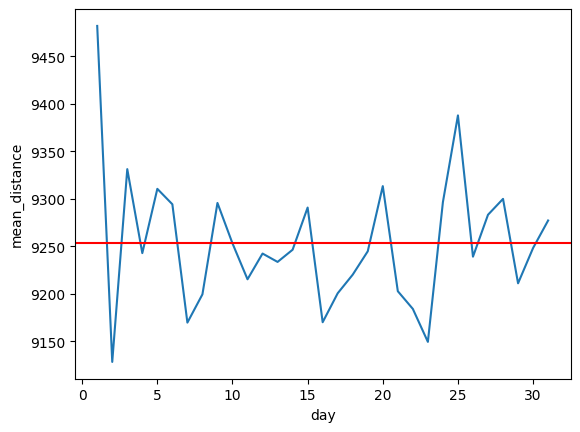

In [ ]:
df.groupby('day', as_index=True)['mean_distance'].mean().plot()
plt.axhline(df['mean_distance'].mean(), color='r')
plt.ylabel('mean_distance')
plt.show()

#### 통합


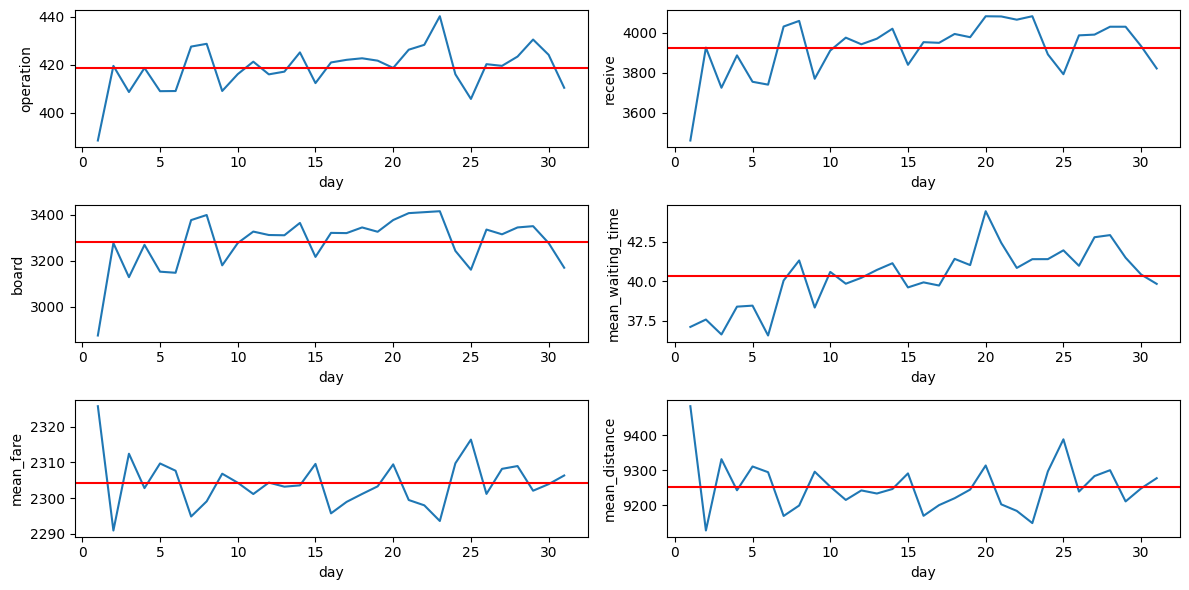

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
df.groupby('day', as_index=True)['operation'].mean().plot()
plt.axhline(df['operation'].mean(), color='r')
plt.ylabel('operation')

plt.subplot(3, 2, 2)
df.groupby('day', as_index=True)['receive'].mean().plot()
plt.axhline(df['receive'].mean(), color='r')
plt.ylabel('receive')

plt.subplot(3, 2, 3)
df.groupby('day', as_index=True)['board'].mean().plot()
plt.axhline(df['board'].mean(), color='r')
plt.ylabel('board')

plt.subplot(3, 2, 4)
df.groupby('day', as_index=True)['mean_waiting_time'].mean().plot()
plt.axhline(df['mean_waiting_time'].mean(), color='r')
plt.ylabel('mean_waiting_time')

plt.subplot(3, 2, 5)
df.groupby('day', as_index=True)['mean_fare'].mean().plot()
plt.axhline(df['mean_fare'].mean(), color='r')
plt.ylabel('mean_fare')

plt.subplot(3, 2, 6)
df.groupby('day', as_index=True)['mean_distance'].mean().plot()
plt.axhline(df['mean_distance'].mean(), color='r')
plt.ylabel('mean_distance')

plt.tight_layout()
plt.show()

### (3) 요일별

#### 차량 운행수

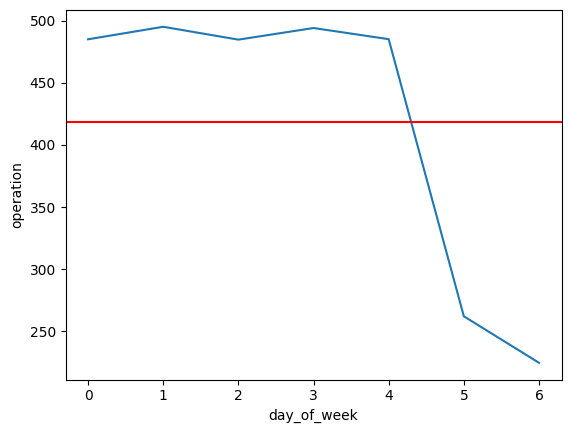

In [ ]:
df.groupby('day_of_week', as_index=True)['operation'].mean().plot()  # (0:월, 1:화, ...)
plt.axhline(df['operation'].mean(), color='r')
plt.ylabel('operation')
plt.show()

#### 접수건, 탑승건

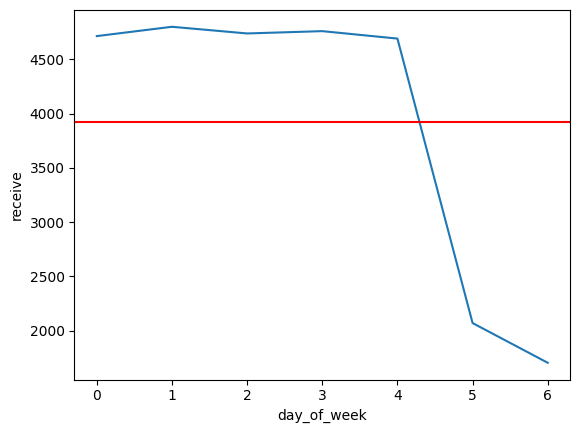

In [ ]:
df.groupby('day_of_week', as_index=True)['receive'].mean().plot()
plt.axhline(df['receive'].mean(), color='r')
plt.ylabel('receive')
plt.show()

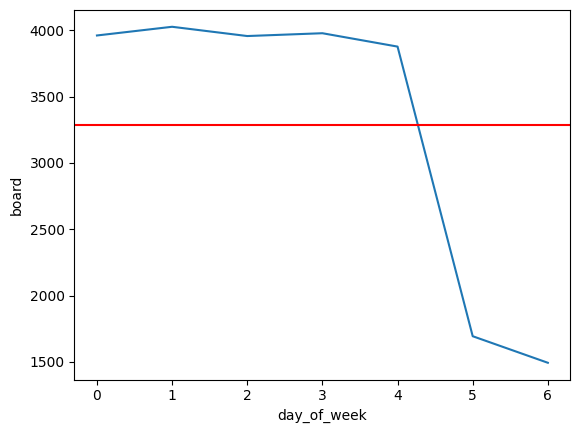

In [ ]:
df.groupby('day_of_week', as_index=True)['board'].mean().plot()
plt.axhline(df['board'].mean(), color='r')
plt.ylabel('board')
plt.show()

#### 대기시간

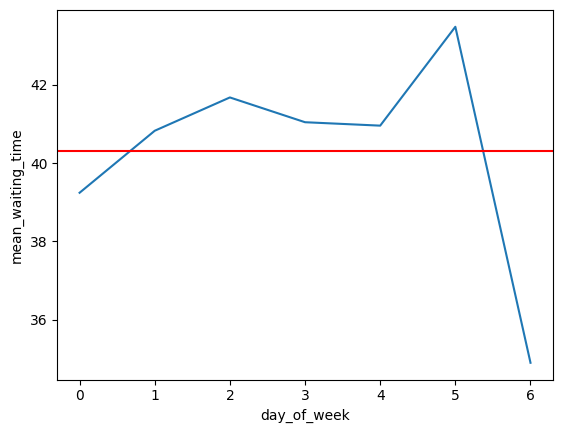

In [ ]:
df.groupby('day_of_week', as_index=True)['mean_waiting_time'].mean().plot()
plt.axhline(df['mean_waiting_time'].mean(), color='r')
plt.ylabel('mean_waiting_time')
plt.show()

#### 운임

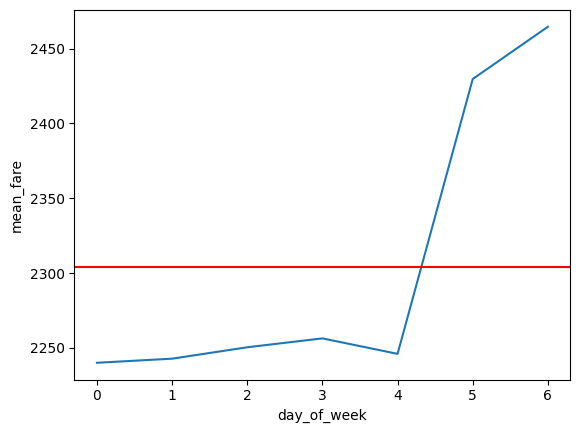

In [ ]:
df.groupby('day_of_week', as_index=True)['mean_fare'].mean().plot()
plt.axhline(df['mean_fare'].mean(), color='r')
plt.ylabel('mean_fare')
plt.show()

#### 이동거리

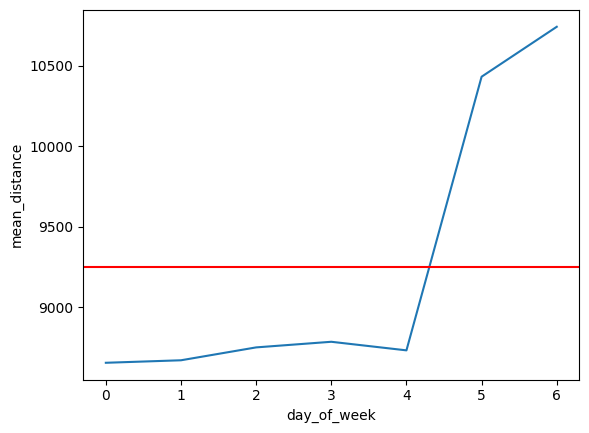

In [ ]:
df.groupby('day_of_week', as_index=True)['mean_distance'].mean().plot()
plt.axhline(df['mean_distance'].mean(), color='r')
plt.ylabel('mean_distance')
plt.show()

#### 통합

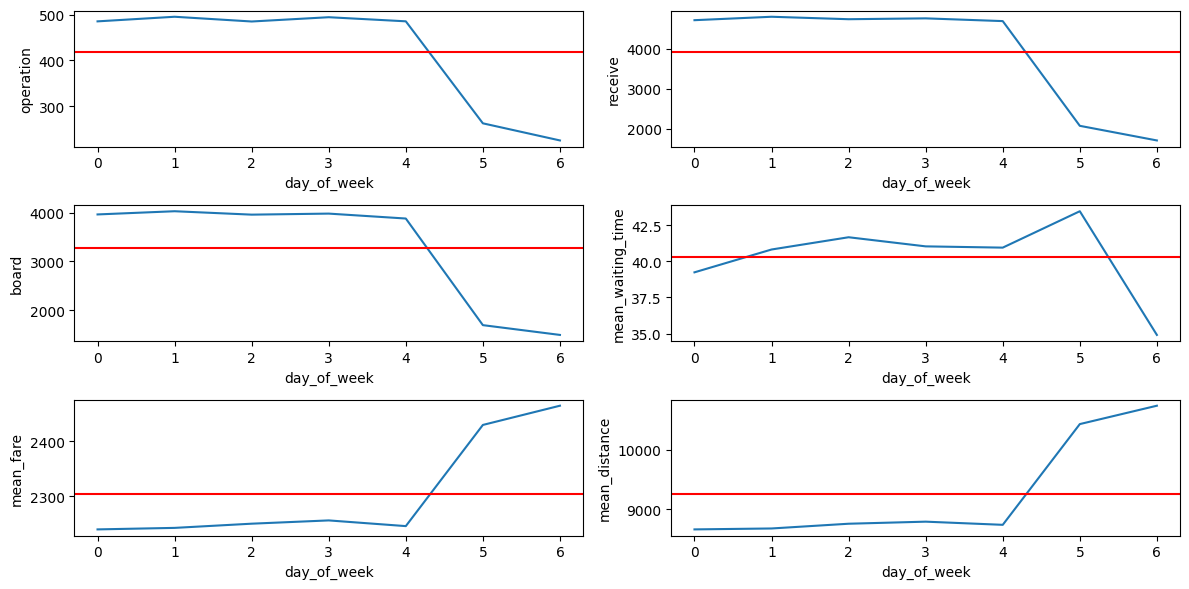

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
df.groupby('day_of_week', as_index=True)['operation'].mean().plot()
plt.axhline(df['operation'].mean(), color='r')
plt.ylabel('operation')

plt.subplot(3, 2, 2)
df.groupby('day_of_week', as_index=True)['receive'].mean().plot()
plt.axhline(df['receive'].mean(), color='r')
plt.ylabel('receive')

plt.subplot(3, 2, 3)
df.groupby('day_of_week', as_index=True)['board'].mean().plot()
plt.axhline(df['board'].mean(), color='r')
plt.ylabel('board')

plt.subplot(3, 2, 4)
df.groupby('day_of_week', as_index=True)['mean_waiting_time'].mean().plot()
plt.axhline(df['mean_waiting_time'].mean(), color='r')
plt.ylabel('mean_waiting_time')

plt.subplot(3, 2, 5)
df.groupby('day_of_week', as_index=True)['mean_fare'].mean().plot()
plt.axhline(df['mean_fare'].mean(), color='r')
plt.ylabel('mean_fare')

plt.subplot(3, 2, 6)
df.groupby('day_of_week', as_index=True)['mean_distance'].mean().plot()
plt.axhline(df['mean_distance'].mean(), color='r')
plt.ylabel('mean_distance')

plt.tight_layout()
plt.show()

### (4) 월별

#### 차량 운행수

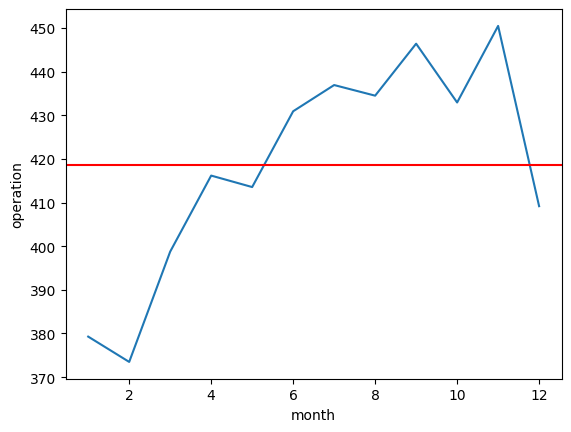

In [ ]:
df.groupby('month', as_index=True)['operation'].mean().plot()
plt.axhline(df['operation'].mean(), color='r')
plt.ylabel('operation')
plt.show()

#### 접수건, 탑승건

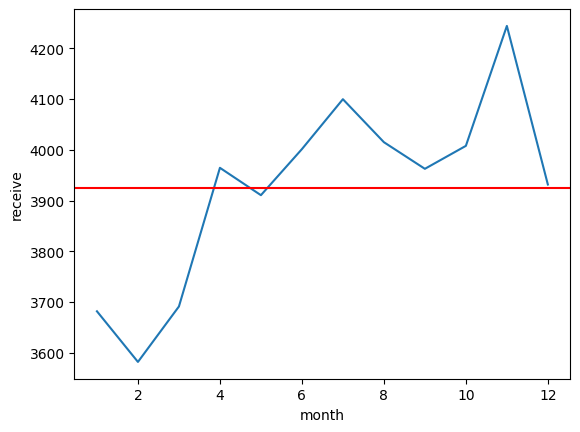

In [ ]:
df.groupby('month', as_index=True)['receive'].mean().plot()
plt.axhline(df['receive'].mean(), color='r')
plt.ylabel('receive')
plt.show()

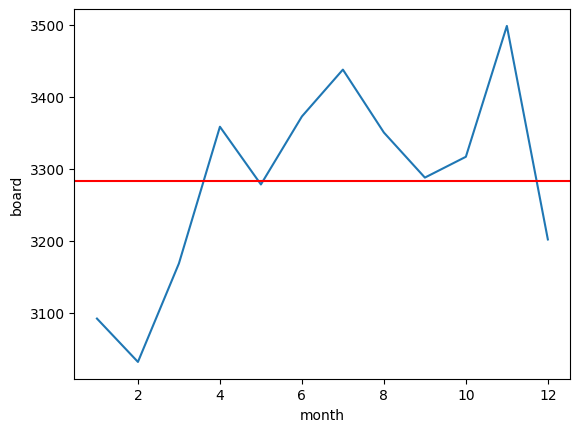

In [ ]:
df.groupby('month', as_index=True)['board'].mean().plot()
plt.axhline(df['board'].mean(), color='r')
plt.ylabel('board')
plt.show()

#### 대기시간

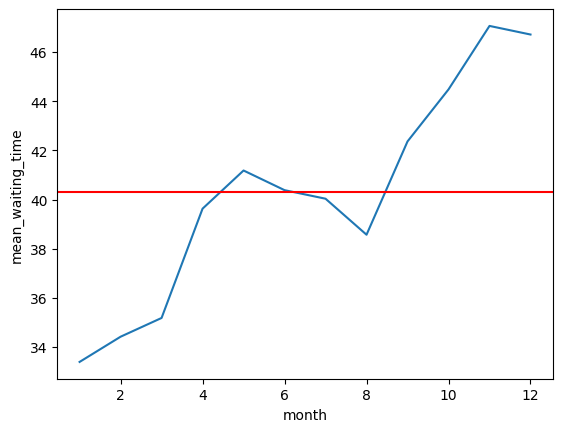

In [ ]:
df.groupby('month', as_index=True)['mean_waiting_time'].mean().plot()
plt.axhline(df['mean_waiting_time'].mean(), color='r')
plt.ylabel('mean_waiting_time')
plt.show()

#### 운임

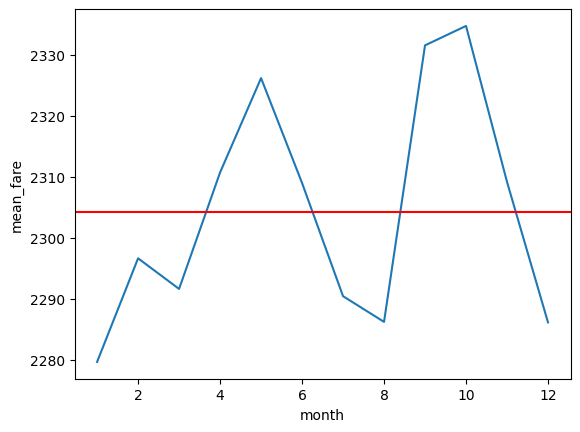

In [ ]:
df.groupby('month', as_index=True)['mean_fare'].mean().plot()
plt.axhline(df['mean_fare'].mean(), color='r')
plt.ylabel('mean_fare')
plt.show()

#### 이동거리

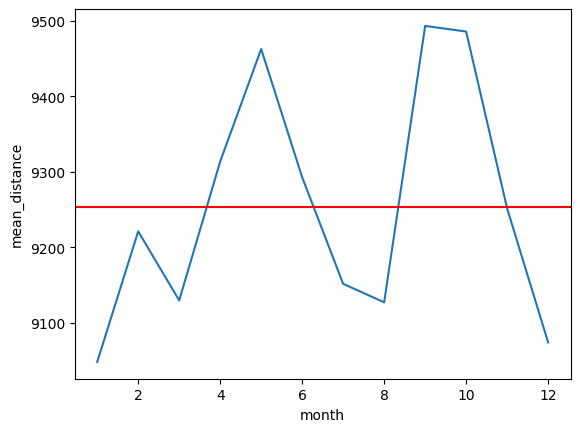

In [ ]:
df.groupby('month', as_index=True)['mean_distance'].mean().plot()
plt.axhline(df['mean_distance'].mean(), color='r')
plt.ylabel('mean_distance')
plt.show()

#### 통합

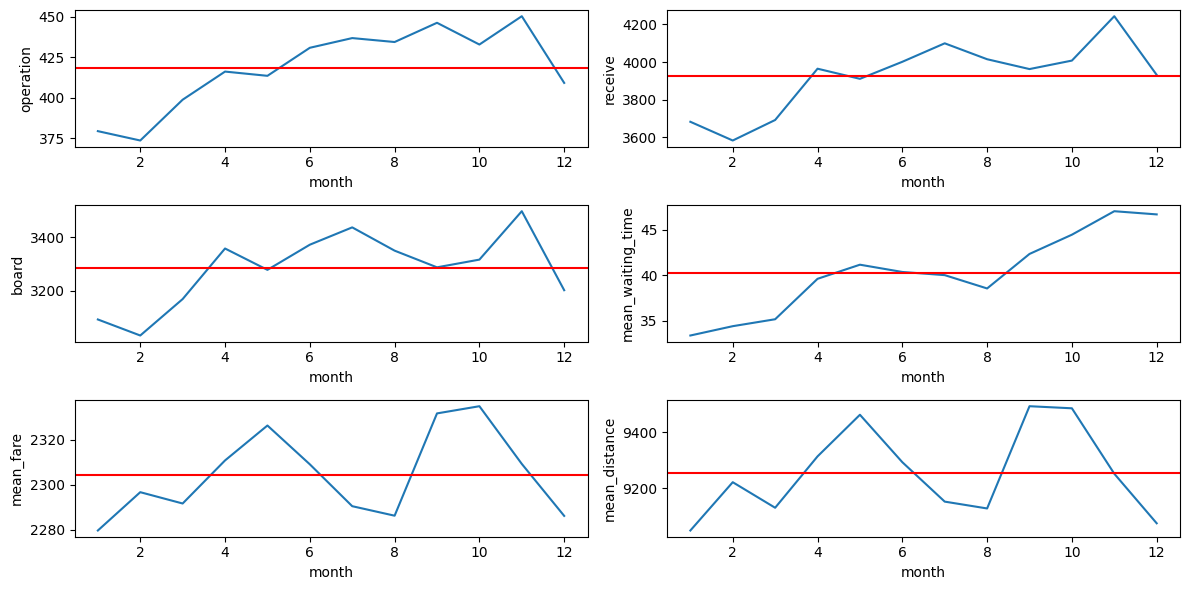

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
df.groupby('month', as_index=True)['operation'].mean().plot()
plt.axhline(df['operation'].mean(), color='r')
plt.ylabel('operation')

plt.subplot(3, 2, 2)
df.groupby('month', as_index=True)['receive'].mean().plot()
plt.axhline(df['receive'].mean(), color='r')
plt.ylabel('receive')

plt.subplot(3, 2, 3)
df.groupby('month', as_index=True)['board'].mean().plot()
plt.axhline(df['board'].mean(), color='r')
plt.ylabel('board')

plt.subplot(3, 2, 4)
df.groupby('month', as_index=True)['mean_waiting_time'].mean().plot()
plt.axhline(df['mean_waiting_time'].mean(), color='r')
plt.ylabel('mean_waiting_time')

plt.subplot(3, 2, 5)
df.groupby('month', as_index=True)['mean_fare'].mean().plot()
plt.axhline(df['mean_fare'].mean(), color='r')
plt.ylabel('mean_fare')

plt.subplot(3, 2, 6)
df.groupby('month', as_index=True)['mean_distance'].mean().plot()
plt.axhline(df['mean_distance'].mean(), color='r')
plt.ylabel('mean_distance')

plt.tight_layout()
plt.show()

### (5) 연도별

#### 차량 운행수

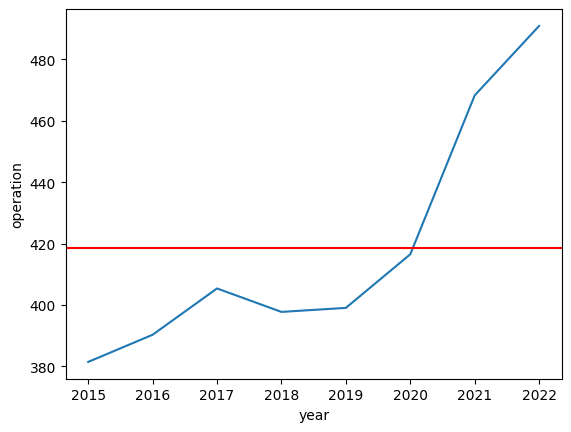

In [ ]:
df.groupby('year', as_index=True)['operation'].mean().plot()
plt.axhline(df['operation'].mean(), color='r')
plt.ylabel('operation')
plt.show()

#### 대기시간

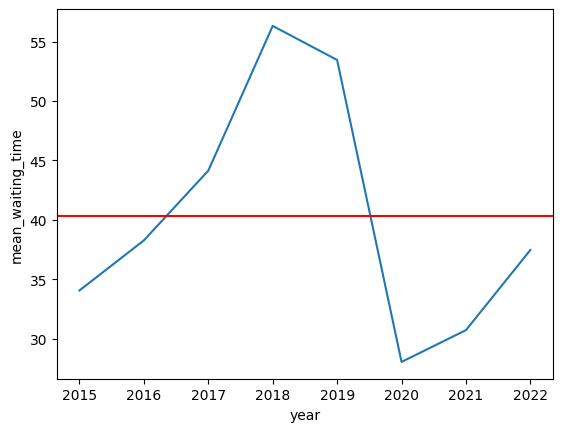

In [ ]:
df.groupby('year', as_index=True)['mean_waiting_time'].mean().plot()
plt.axhline(df['mean_waiting_time'].mean(), color='r')
plt.ylabel('mean_waiting_time')
plt.show()

#### 통합

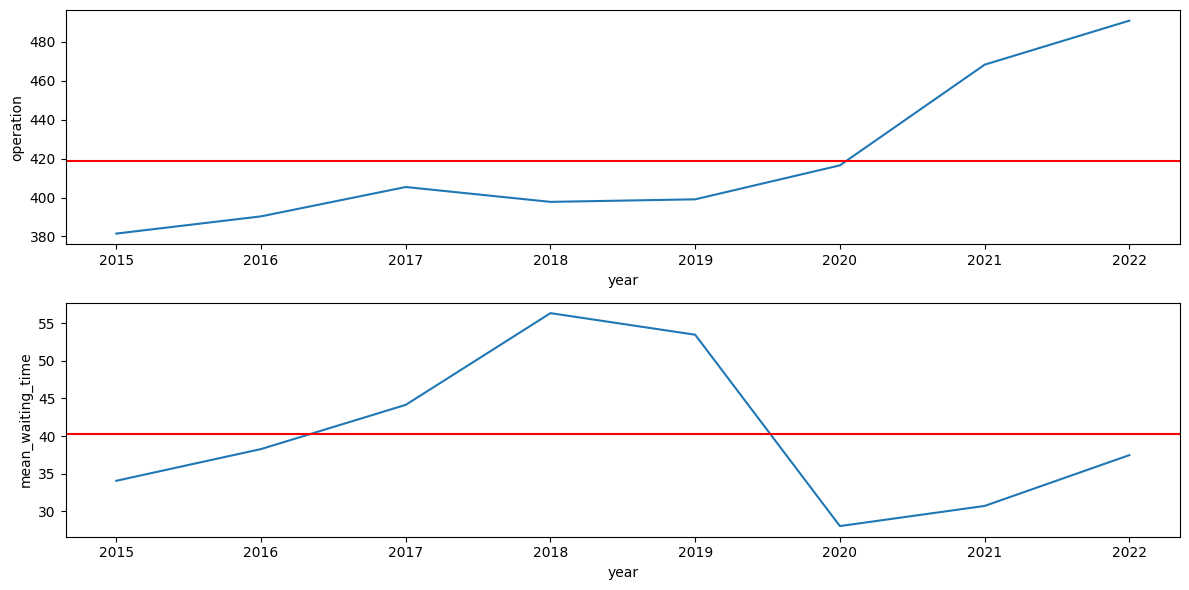

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
df.groupby('year', as_index=True)['operation'].mean().plot()
plt.axhline(df['operation'].mean(), color='r')
plt.ylabel('operation')

plt.subplot(2, 1, 2)
df.groupby('year', as_index=True)['mean_waiting_time'].mean().plot()
plt.axhline(df['mean_waiting_time'].mean(), color='r')
plt.ylabel('mean_waiting_time')

plt.tight_layout()
plt.show()

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [ ]:
data['Date'] = data['Date'].shift(-1)
data['mean_waiting_time'] = data['mean_waiting_time'].shift(-1)
data.head()

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance
0,2015-01-02,213,1023,924,17.2,2427,10764
1,2015-01-03,420,3158,2839,26.2,2216,8611
2,2015-01-04,209,1648,1514,24.5,2377,10198
3,2015-01-05,196,1646,1526,26.2,2431,10955
4,2015-01-06,421,4250,3730,23.6,2214,8663


In [ ]:
data_w[1096:1102]

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
1096,2015-01-01,-4.3,-9.8,0.0,52.0,33.0,9.79
1097,2015-01-02,-2.0,-8.9,0.0,63.0,28.0,9.07
1098,2015-01-03,2.4,-9.2,0.0,73.0,37.0,8.66
1099,2015-01-04,8.2,0.2,0.0,89.0,58.0,5.32
1100,2015-01-05,7.9,-0.9,0.0,95.0,52.0,6.48
1101,2015-01-06,4.1,-7.4,3.4,98.0,29.0,10.47


### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

In [ ]:
data_m = pd.merge(data, data_w, how='left', on='Date')
data_m['Date'] = data_m['Date'].shift(1)
data_m.head()

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,None,213,1023,924,17.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07
1,2015-01-02,420,3158,2839,26.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66
2,2015-01-03,209,1648,1514,24.5,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32
3,2015-01-04,196,1646,1526,26.2,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48
4,2015-01-05,421,4250,3730,23.6,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47


### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [ ]:
data_m['Date'] = pd.to_datetime(data_m['Date'], format='%Y-%m-%d')  # 날짜 타입으로 변환

In [ ]:
data_m.dropna(axis=0, inplace=True)

In [ ]:
data_m['day_of_week'] = data_m['Date'].dt.weekday  # 요일(0:월, 1:화, ...)
data_m['month'] = data_m['Date'].dt.month  # 월
data_m['year'] = data_m['Date'].dt.year  # 연

data_m['day_of_week'].astype('int')
data_m['month'].astype('int')
data_m['year'].astype('int')

# 3-5 : 봄(0) 6-8 : 여름(1) 9-11 : 가을(2) 12-2 : 겨울(3)
data_m['season'] = data_m['month']
data_m.loc[data_m['season'].isin([3, 4, 5]), 'season'] = 'Spring'
data_m.loc[data_m['season'].isin([6, 7, 8]), 'season'] = 'Summer'
data_m.loc[data_m['season'].isin([9, 10, 11]), 'season'] = 'Fall'
data_m.loc[data_m['season'].isin([12, 1, 2]), 'season'] = 'Winter'

data_m.head()

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),day_of_week,month,year,season
1,2015-01-02,420,3158,2839,26.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,4,1,2015,Winter
2,2015-01-03,209,1648,1514,24.5,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,5,1,2015,Winter
3,2015-01-04,196,1646,1526,26.2,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,6,1,2015,Winter
4,2015-01-05,421,4250,3730,23.6,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,0,1,2015,Winter
5,2015-01-06,417,3991,3633,24.7,2211,8545,-1.0,-8.8,0.0,42.0,24.0,10.12,1,1,2015,Winter


In [ ]:
def day_of_week_name(data):
    dic = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    data['day_of_week'] = dic[data['day_of_week']]
    return data

def month_name(data):
    dic = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month'] = dic[data['month']]
    return data

data_m = data_m.apply(day_of_week_name, axis=1)
data_m = data_m.apply(month_name, axis=1)

data_m['day_of_week'] = pd.Categorical(data_m['day_of_week'], categories=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)
data_m['month'] = pd.Categorical(data_m['month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'], ordered=True)
data_m['season'] = pd.Categorical(data_m['season'], categories=['Spring', 'Summer', 'Fall', 'Winter'], ordered=True)

data_m.head()

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),day_of_week,month,year,season
1,2015-01-02,420,3158,2839,26.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,Fri,Jan,2015,Winter
2,2015-01-03,209,1648,1514,24.5,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,Sat,Jan,2015,Winter
3,2015-01-04,196,1646,1526,26.2,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,Sun,Jan,2015,Winter
4,2015-01-05,421,4250,3730,23.6,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,Mon,Jan,2015,Winter
5,2015-01-06,417,3991,3633,24.7,2211,8545,-1.0,-8.8,0.0,42.0,24.0,10.12,Tue,Jan,2015,Winter


In [ ]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2920 entries, 1 to 2920
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2920 non-null   datetime64[ns]
 1   operation          2920 non-null   int64         
 2   receive            2920 non-null   int64         
 3   board              2920 non-null   int64         
 4   mean_waiting_time  2920 non-null   float64       
 5   mean_fare          2920 non-null   int64         
 6   mean_distance      2920 non-null   int64         
 7   temp_max           2920 non-null   float64       
 8   temp_min           2920 non-null   float64       
 9   rain(mm)           2920 non-null   float64       
 10  humidity_max(%)    2920 non-null   float64       
 11  humidity_min(%)    2920 non-null   float64       
 12  sunshine(MJ/m2)    2920 non-null   float64       
 13  day_of_week        2920 non-null   category      
 14  month   

In [ ]:
data_m.head()

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),day_of_week,month,year,season
1,2015-01-02,420,3158,2839,26.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,Fri,Jan,2015,Winter
2,2015-01-03,209,1648,1514,24.5,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,Sat,Jan,2015,Winter
3,2015-01-04,196,1646,1526,26.2,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,Sun,Jan,2015,Winter
4,2015-01-05,421,4250,3730,23.6,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,Mon,Jan,2015,Winter
5,2015-01-06,417,3991,3633,24.7,2211,8545,-1.0,-8.8,0.0,42.0,24.0,10.12,Tue,Jan,2015,Winter


#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [ ]:
!pip install workalendar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* 간단 사용법

In [ ]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

,0,1
0,2023-01-01,New year
1,2023-01-21,Korean New Year's Day
2,2023-01-22,Korean New Year's Day
3,2023-01-23,Korean New Year's Day
4,2023-03-01,Independence Day
5,2023-05-05,Children's Day
6,2023-05-26,Buddha's Birthday
7,2023-06-06,Memorial Day
8,2023-08-15,Liberation Day
9,2023-09-28,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [ ]:
holidays_df = pd.DataFrame(cal.holidays(2015))
for i in range(2016, 2023):
    temp = pd.DataFrame(cal.holidays(i))
    holidays_df = pd.concat([holidays_df, temp], axis=0, join='outer')

holidays_df.columns = ['Date', 'holiday']
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'], format='%Y-%m-%d')  # 날짜 타입으로 변환
holidays_df

,Date,holiday
0,2015-01-01,New year
1,2015-02-18,Korean New Year's Day
2,2015-02-19,Korean New Year's Day
3,2015-02-20,Korean New Year's Day
4,2015-03-01,Independence Day
...,...,...
10,2022-09-10,Midautumn Festival
11,2022-09-11,Midautumn Festival
12,2022-10-03,National Foundation Day
13,2022-10-09,Hangul Day


* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [ ]:
data_m = pd.merge(data_m, holidays_df, how='left', on='Date')
data_m['holiday'].fillna(0, inplace=True)
data_m.loc[data_m['holiday'] != 0, 'holiday'] = 1

In [ ]:
data_m.tail(10)

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),day_of_week,month,year,season,holiday
2911,2022-12-21,628,5936,4815,56.4,2150,7832,-2.6,-10.9,0.0,75.0,45.0,10.05,Wed,Dec,2022,Winter,0
2912,2022-12-22,625,5899,4716,51.7,2188,8051,-9.2,-13.7,0.0,65.0,53.0,10.76,Thu,Dec,2022,Winter,0
2913,2022-12-23,607,5570,4361,29.4,2159,8003,-2.1,-13.5,0.0,69.0,40.0,10.92,Fri,Dec,2022,Winter,0
2914,2022-12-24,308,2279,1910,38.7,2367,9806,-0.2,-9.5,0.0,81.0,47.0,10.89,Sat,Dec,2022,Winter,0
2915,2022-12-25,217,1945,1588,39.2,2416,10212,1.5,-7.9,0.0,85.0,46.0,8.27,Sun,Dec,2022,Winter,1
2916,2022-12-26,603,5555,4605,44.4,2163,7889,3.0,-7.3,0.0,86.0,51.0,10.25,Mon,Dec,2022,Winter,0
2917,2022-12-27,669,5635,4654,44.8,2198,8178,-0.3,-5.4,0.1,92.0,40.0,10.86,Tue,Dec,2022,Winter,0
2918,2022-12-28,607,5654,4648,52.5,2161,7882,1.7,-7.8,0.0,71.0,34.0,10.88,Wed,Dec,2022,Winter,0
2919,2022-12-29,581,5250,4247,38.3,2229,8433,2.1,-4.0,0.0,87.0,38.0,10.84,Thu,Dec,2022,Winter,0
2920,2022-12-30,600,5293,4200,33.7,2183,8155,-4.4,-4.4,0.0,66.0,66.0,0.00,Fri,Dec,2022,Winter,0


In [ ]:
data_m['holiday'] = data_m['holiday'].astype('int')
data_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 0 to 2920
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2921 non-null   datetime64[ns]
 1   operation          2921 non-null   int64         
 2   receive            2921 non-null   int64         
 3   board              2921 non-null   int64         
 4   mean_waiting_time  2921 non-null   float64       
 5   mean_fare          2921 non-null   int64         
 6   mean_distance      2921 non-null   int64         
 7   temp_max           2921 non-null   float64       
 8   temp_min           2921 non-null   float64       
 9   rain(mm)           2921 non-null   float64       
 10  humidity_max(%)    2921 non-null   float64       
 11  humidity_min(%)    2921 non-null   float64       
 12  sunshine(MJ/m2)    2921 non-null   float64       
 13  day_of_week        2921 non-null   category      
 14  month   

#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [ ]:
data_m['mean_waiting_time_MA7'] = data_m['mean_waiting_time'].rolling(7, min_periods=1).mean()
data_m.head()

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),day_of_week,month,year,season,holiday,mean_waiting_time_MA7
0,2015-01-02,420,3158,2839,26.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,Fri,Jan,2015,Winter,0,26.200000
1,2015-01-03,209,1648,1514,24.5,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,Sat,Jan,2015,Winter,0,25.350000
2,2015-01-04,196,1646,1526,26.2,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,Sun,Jan,2015,Winter,0,25.633333
3,2015-01-05,421,4250,3730,23.6,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,Mon,Jan,2015,Winter,0,25.125000
4,2015-01-06,417,3991,3633,24.7,2211,8545,-1.0,-8.8,0.0,42.0,24.0,10.12,Tue,Jan,2015,Winter,0,25.040000


#### 4) 탑승률

In [ ]:
data_m['boarding_rate'] = data_m['board'] / data_m['receive'] * 100
data_m.head()

,Date,operation,receive,board,mean_waiting_time,mean_fare,mean_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),day_of_week,month,year,season,holiday,mean_waiting_time_MA7,boarding_rate
0,2015-01-02,420,3158,2839,26.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,Fri,Jan,2015,Winter,0,26.200000,89.898670
1,2015-01-03,209,1648,1514,24.5,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,Sat,Jan,2015,Winter,0,25.350000,91.868932
2,2015-01-04,196,1646,1526,26.2,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,Sun,Jan,2015,Winter,0,25.633333,92.709599
3,2015-01-05,421,4250,3730,23.6,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,Mon,Jan,2015,Winter,0,25.125000,87.764706
4,2015-01-06,417,3991,3633,24.7,2211,8545,-1.0,-8.8,0.0,42.0,24.0,10.12,Tue,Jan,2015,Winter,0,25.040000,91.029817


## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl

In [ ]:
import joblib

path = '/content/drive/MyDrive/16 Mini Project06/3-4일차. 장애인 이동권 개선을 위한 장애인 콜택시 대기시간 예측/'
joblib.dump(data_m, path + 'data1.pkl')

['/content/drive/MyDrive/16 Mini Project06/3-4일차. 장애인 이동권 개선을 위한 장애인 콜택시 대기시간 예측/data1.pkl']